In [6]:
import os
import numpy as np
from cv2 import imread
import cv2 as cv
path = 'garbage/images_evaluation'

# def loadimgs(path, n = 0):
#     X=[]
#     y=[]
#     cat_dict={}
#     lang_dict={}
#     curr_y = n
    
#     for alphabet in os.listdir(path):
#         print('loading alphatbet: ' + alphabet)
#         lang_dict[alphabet]=[curr_y, None]
#         alphabet_path = os.path.join()
        
#         for letter in alphabet_path:
#             cat_dict[curr_y] = (alphabet,)

In [7]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
   

    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [8]:
X,y,c = loadimgs(path)

loading alphabet: Angelic
loading alphabet: Atemayar_Qelisayer
loading alphabet: Atlantean
loading alphabet: Aurek-Besh
loading alphabet: Avesta
loading alphabet: Ge_ez
loading alphabet: Glagolitic
loading alphabet: Gurmukhi
loading alphabet: Kannada
loading alphabet: Keble
loading alphabet: Malayalam
loading alphabet: Manipuri
loading alphabet: Mongolian
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Oriya
loading alphabet: Sylheti
loading alphabet: Syriac_(Serto)
loading alphabet: Tengwar
loading alphabet: Tibetan
loading alphabet: ULOG


In [9]:
import pickle 

with open('garbage/val.pickle', 'wb') as f:
    pickle.dump((X,c), f)

In [10]:
# def get_batch(batch_size, s='train'):
#     n_classes, n_samples, w, h = X.shape
#     categories = np.random.choice(n_classes, size=(batch_size,),replace=False)
#     pairs = [np.zeros((batch_size,h,w,1)) for _ in range(2)]
    
#     targets = np.zeros((batch_size)) 
#     targets[batch_size//2:] = 1
    
#     for i in range(batch_size):
#         category = categories[i]
#         idx_1 = np.randint(0, n_examples)
#         pairs[0][i,:,:,:]=X[category,idx_1].reshape(h,w,1)
        
#         idx_2 = np.randint(0, n_examples)
        
#         if i >= batch_size//2:
#             category_2 = category
        
#         else 
import numpy.random as rng
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
#     if s == 'train':
#         X = Xtrain
#         categories = train_classes
#     else:
#         X = Xval
#         categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [11]:
X.shape

(659, 20, 105, 105)

2 4
[0. 0. 1. 1.]


<Figure size 432x288 with 0 Axes>

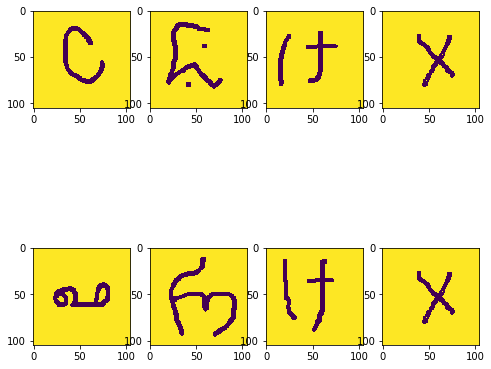

In [7]:
import  tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
def siamese(input_shape):
    left_in = Input(input_shape)
    right_in = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128,(7,7),activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128,(4,4),activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(256,(4,4),activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    
    print(model.summary())
    
    endmodel_l = model(left_in)
    endmodel_r = model(right_in)
    
    
    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))
    L1_distance = L1_layer([endmodel_l, endmodel_r])
    
    
    prediction =  Dense(1, activation='sigmoid')(L1_distance)
    
    simense = Model(inputs=[left_in, right_in], outputs=prediction)
    print(simense.summary())
    return simense


model = siamese((105,105,1))
optimizer = Adam(lr=0.00006)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         5

In [12]:
import numpy.random as rng
from sklearn.utils import shuffle

In [13]:
import os

class simense_loader:
    
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            filepath = os.path.join(path, name+'.pickle')
            print('loading from ' + filepath)
            with open(filepath, 'rb') as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c
                
    
    def getBatch(self, batch_size, s = "train"):
        X = self.data[s]
        n_classes, n_examples, w, h, = X.shape
        categories = rng.choice(n_classes, size=(batch_size,), replace=False)
        
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        targets[batch_size//2:]=1
        
        for i in range(batch_size):
            category=categories[i]
            idx_1 = rng.randint(0,n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0,n_examples)
            
            if i >=batch_size//2:
                category_2 = category
            else:
                category_2 = (category+rng.randint(1, n_classes))%n_classes
                
            pairs[1][i,:,:,:]=X[category_2,idx_2].reshape(w,h,1)
        return pairs, targets
    
    def generate(batch_size, s="train"):
        while True:
            pairs, targets = self.getBatch(batch_size, s)
            yield pairs, targets
            
    def make_one_shot_task(self, N, s="val", language=None):
        
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        
        indices = rng.randint(0, n_examples, size=(N,))
        
        if language is not None:
            low, high = self.categories[s][language]
            
            if high - low < N:
                raise ValueError("Not enough letter in laungage")
            categories = rng.choice(range(low, high),  size=(N,), replace=False)
        else:
            categories = rng.choice(n_classes, size=(N,), replace=False)
            
        true_category = categories[0]
        
        ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
        
        test_image = np.asarray([X[true_category,ex1,:,:]]*N)
        
        support_set = X[categories, indices, :, :]
        support_set[0,:,:] = X[true_category, ex2]
        support_set = support_set.reshape(N,w,h,1)
        
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image, support_set]
        return pairs, targets
    
    
    def test_oneshot(self, model, N, k, s='val', verbose=0):
        n_correct = 0
        
        for i in range(k):
            inputs, targets = self.make_one_shot_task(N,s)
            probs = model.predict(inputs)
            
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
            
        per = n_correct/k*100
        if verbose:
            print("Got persentage{} ".format(per))
        return per
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
            
data_path = 'garbage/'
loader = simense_loader(data_path)

loading from garbage/train.pickle
loading from garbage/val.pickle


In [17]:
model.load_weights('garbage/models/siamese1.h5')

In [20]:
eval_every = 150
loss_every = 200
batch_size = 32
n_iter = 8000
N_way = 20
n_val = 250
best = -1


for i in range(1,n_iter):
    inputs, targets=loader.getBatch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    print("\n----------------\n")
    print("loss {}".format(loss))
    if i % eval_every == 0:
        val_acc = loader.test_oneshot(model, N_way, n_val)
        if val_acc > best: 
            print("current best {}".format(val_acc))
            model.save_weights("garbage/models/siamese1.h5")
            best = val_acc
            
    if i % loss_every==0:
        print("loss after{} is {:.2f}".format(i,loss))
        



----------------

loss 0.4228912591934204

----------------

loss 0.24688132107257843

----------------

loss 0.3466843068599701

----------------

loss 0.5257420539855957

----------------

loss 0.5283678770065308

----------------

loss 0.4371795058250427

----------------

loss 0.43171411752700806

----------------

loss 0.332267701625824

----------------

loss 0.591228723526001

----------------

loss 0.35448116064071655

----------------

loss 0.3592451214790344

----------------

loss 0.44268834590911865

----------------

loss 0.41278964281082153

----------------

loss 0.4156711995601654

----------------

loss 0.38542991876602173

----------------

loss 0.44325748085975647

----------------

loss 0.404827356338501

----------------

loss 0.2813400626182556

----------------

loss 0.3464716076850891

----------------

loss 0.40146201848983765

----------------

loss 0.4331561028957367

----------------

loss 0.339585542678833

----------------

loss 0.3169477880001068

------


----------------

loss 0.30840519070625305

----------------

loss 0.30461347103118896

----------------

loss 0.2787993550300598

----------------

loss 0.49375781416893005

----------------

loss 0.36192479729652405

----------------

loss 0.431572824716568

----------------

loss 0.3316684365272522

----------------

loss 0.3829095661640167

----------------

loss 0.26527804136276245

----------------

loss 0.3609313368797302
loss after200 is 0.36

----------------

loss 0.5793888568878174

----------------

loss 0.40898633003234863

----------------

loss 0.4184435307979584

----------------

loss 0.4035712778568268

----------------

loss 0.2934873700141907

----------------

loss 0.4059559106826782

----------------

loss 0.44145315885543823

----------------

loss 0.3421304523944855

----------------

loss 0.3628461956977844

----------------

loss 0.20722775161266327

----------------

loss 0.34801632165908813

----------------

loss 0.4803866147994995

----------------

loss 


----------------

loss 0.40658268332481384

----------------

loss 0.29530391097068787

----------------

loss 0.3378811478614807

----------------

loss 0.2965115010738373

----------------

loss 0.29151880741119385

----------------

loss 0.402417927980423

----------------

loss 0.26881545782089233

----------------

loss 0.29880356788635254

----------------

loss 0.41814786195755005

----------------

loss 0.2506183981895447

----------------

loss 0.22513917088508606

----------------

loss 0.33094799518585205

----------------

loss 0.41448330879211426

----------------

loss 0.3172875642776489

----------------

loss 0.2761463522911072

----------------

loss 0.26106804609298706

----------------

loss 0.3191453814506531

----------------

loss 0.33275821805000305

----------------

loss 0.269847571849823

----------------

loss 0.2145441323518753

----------------

loss 0.2708457410335541

----------------

loss 0.29234540462493896
loss after400 is 0.29

----------------

los


----------------

loss 0.275552362203598

----------------

loss 0.29478126764297485

----------------

loss 0.20579779148101807

----------------

loss 0.3442380726337433

----------------

loss 0.36795276403427124

----------------

loss 0.4340066909790039

----------------

loss 0.2807554304599762

----------------

loss 0.32637572288513184

----------------

loss 0.29644083976745605

----------------

loss 0.1976836621761322

----------------

loss 0.34964117407798767

----------------

loss 0.3095611333847046

----------------

loss 0.23676513135433197

----------------

loss 0.290344774723053

----------------

loss 0.3254626393318176

----------------

loss 0.3589644432067871

----------------

loss 0.2433183193206787

----------------

loss 0.3399132490158081

----------------

loss 0.30490225553512573

----------------

loss 0.24580565094947815

----------------

loss 0.3295210003852844

----------------

loss 0.2708812355995178

----------------

loss 0.3160323202610016

---


----------------

loss 0.34774839878082275

----------------

loss 0.2823622226715088

----------------

loss 0.20487909018993378

----------------

loss 0.22414958477020264

----------------

loss 0.36765849590301514

----------------

loss 0.4216381311416626

----------------

loss 0.2962798476219177

----------------

loss 0.3812984228134155

----------------

loss 0.2369605451822281

----------------

loss 0.3041767477989197

----------------

loss 0.3260273337364197

----------------

loss 0.2597109079360962

----------------

loss 0.2465713918209076

----------------

loss 0.3891570270061493

----------------

loss 0.328798770904541

----------------

loss 0.40660780668258667

----------------

loss 0.30236148834228516

----------------

loss 0.29656165838241577

----------------

loss 0.38103532791137695

----------------

loss 0.3727337121963501

----------------

loss 0.23943674564361572

----------------

loss 0.22972820699214935

----------------

loss 0.3358491361141205

-


----------------

loss 0.2916455566883087

----------------

loss 0.23570016026496887

----------------

loss 0.24609652161598206

----------------

loss 0.26225510239601135

----------------

loss 0.3978447914123535

----------------

loss 0.3766728639602661

----------------

loss 0.17030206322669983

----------------

loss 0.1870882362127304

----------------

loss 0.3342902660369873

----------------

loss 0.3652820587158203

----------------

loss 0.18268032371997833

----------------

loss 0.2645741105079651

----------------

loss 0.2624189853668213

----------------

loss 0.2930935025215149

----------------

loss 0.3298487067222595

----------------

loss 0.25282275676727295

----------------

loss 0.4333451986312866

----------------

loss 0.3148682415485382

----------------

loss 0.41406410932540894

----------------

loss 0.30056700110435486

----------------

loss 0.4272794723510742

----------------

loss 0.3554929494857788

----------------

loss 0.18895849585533142

-


----------------

loss 0.3323279023170471

----------------

loss 0.341938853263855

----------------

loss 0.2770422697067261

----------------

loss 0.20985615253448486

----------------

loss 0.22066602110862732

----------------

loss 0.22920316457748413

----------------

loss 0.2082916796207428

----------------

loss 0.28636693954467773

----------------

loss 0.2485990822315216

----------------

loss 0.18562151491641998

----------------

loss 0.31743669509887695

----------------

loss 0.13720059394836426

----------------

loss 0.15970419347286224

----------------

loss 0.27552634477615356

----------------

loss 0.23546183109283447

----------------

loss 0.2883443534374237

----------------

loss 0.26079052686691284

----------------

loss 0.2829877436161041

----------------

loss 0.2074350118637085

----------------

loss 0.1390775740146637

----------------

loss 0.4019702970981598

----------------

loss 0.3725895285606384

----------------

loss 0.33258378505706787



loss 0.20743238925933838

----------------

loss 0.31127849221229553

----------------

loss 0.22213810682296753

----------------

loss 0.348876416683197

----------------

loss 0.18917271494865417

----------------

loss 0.14371097087860107

----------------

loss 0.2171436846256256

----------------

loss 0.4138643145561218

----------------

loss 0.2182176560163498

----------------

loss 0.2542010545730591

----------------

loss 0.30499467253685

----------------

loss 0.5936035513877869

----------------

loss 0.15943019092082977

----------------

loss 0.25461578369140625

----------------

loss 0.19070975482463837

----------------

loss 0.1963842511177063

----------------

loss 0.17285141348838806

----------------

loss 0.20253734290599823

----------------

loss 0.16294775903224945

----------------

loss 0.23348110914230347

----------------

loss 0.2604507803916931

----------------

loss 0.3268619775772095

----------------

loss 0.35284629464149475

----------------




----------------

loss 0.24074161052703857

----------------

loss 0.19552317261695862

----------------

loss 0.253596693277359

----------------

loss 0.2591419219970703

----------------

loss 0.2306632399559021

----------------

loss 0.47015148401260376

----------------

loss 0.1308538019657135

----------------

loss 0.16322940587997437

----------------

loss 0.2389879673719406

----------------

loss 0.35167115926742554

----------------

loss 0.1774432361125946

----------------

loss 0.27910372614860535

----------------

loss 0.21412119269371033

----------------

loss 0.37187430262565613

----------------

loss 0.42816489934921265

----------------

loss 0.14258159697055817

----------------

loss 0.20275427401065826

----------------

loss 0.31245875358581543

----------------

loss 0.1544998586177826

----------------

loss 0.2396308034658432

----------------

loss 0.3056178092956543

----------------

loss 0.22488811612129211

----------------

loss 0.3669615983963012


----------------

loss 0.20140694081783295

----------------

loss 0.348871111869812

----------------

loss 0.26936212182044983

----------------

loss 0.2420104593038559

----------------

loss 0.34437865018844604

----------------

loss 0.2824189066886902

----------------

loss 0.24993610382080078

----------------

loss 0.17902275919914246

----------------

loss 0.20717853307724

----------------

loss 0.27433058619499207

----------------

loss 0.19712164998054504

----------------

loss 0.2235586792230606

----------------

loss 0.2548500895500183

----------------

loss 0.17297720909118652

----------------

loss 0.21746456623077393

----------------

loss 0.11374176293611526

----------------

loss 0.31707867980003357

----------------

loss 0.22691631317138672

----------------

loss 0.26081377267837524

----------------

loss 0.30620038509368896

----------------

loss 0.22385375201702118

----------------

loss 0.14347098767757416

----------------

loss 0.143261879682540


----------------

loss 0.15838706493377686

----------------

loss 0.2085203230381012

----------------

loss 0.38328132033348083

----------------

loss 0.25188538432121277

----------------

loss 0.5276292562484741

----------------

loss 0.31525126099586487

----------------

loss 0.2799018323421478

----------------

loss 0.25112292170524597

----------------

loss 0.3141275644302368

----------------

loss 0.14455020427703857

----------------

loss 0.31910204887390137

----------------

loss 0.3071635067462921

----------------

loss 0.16324609518051147

----------------

loss 0.14002147316932678

----------------

loss 0.40828824043273926

----------------

loss 0.21379482746124268

----------------

loss 0.28809165954589844

----------------

loss 0.13464447855949402

----------------

loss 0.21079890429973602

----------------

loss 0.12184370309114456

----------------

loss 0.29792195558547974

----------------

loss 0.2466946393251419

----------------

loss 0.243847683072


----------------

loss 0.26174184679985046

----------------

loss 0.1380041390657425

----------------

loss 0.30158859491348267

----------------

loss 0.3866364359855652

----------------

loss 0.31646549701690674

----------------

loss 0.15666386485099792

----------------

loss 0.22369912266731262

----------------

loss 0.2929937243461609

----------------

loss 0.20110946893692017

----------------

loss 0.2599527835845947

----------------

loss 0.2546948194503784

----------------

loss 0.12678122520446777

----------------

loss 0.25533726811408997

----------------

loss 0.1590598225593567

----------------

loss 0.19148388504981995

----------------

loss 0.19195565581321716

----------------

loss 0.26266366243362427

----------------

loss 0.18808043003082275

----------------

loss 0.17573262751102448

----------------

loss 0.17044773697853088

----------------

loss 0.19668707251548767

----------------

loss 0.2138933539390564

----------------

loss 0.2998859286308


----------------

loss 0.19293206930160522

----------------

loss 0.096602663397789

----------------

loss 0.16171959042549133

----------------

loss 0.2904188632965088

----------------

loss 0.17420503497123718

----------------

loss 0.28955283761024475

----------------

loss 0.22002387046813965

----------------

loss 0.3772525191307068

----------------

loss 0.21066176891326904

----------------

loss 0.3433677852153778

----------------

loss 0.12332653999328613

----------------

loss 0.5500670075416565

----------------

loss 0.16883818805217743

----------------

loss 0.15233074128627777

----------------

loss 0.1603740155696869

----------------

loss 0.2036253660917282

----------------

loss 0.15725359320640564

----------------

loss 0.15348407626152039

----------------

loss 0.22382043302059174

----------------

loss 0.28085315227508545

----------------

loss 0.2629331052303314

----------------

loss 0.1865866482257843

----------------

loss 0.1967182010412216


----------------

loss 0.23380827903747559

----------------

loss 0.17527899146080017

----------------

loss 0.17214460670948029

----------------

loss 0.22365634143352509

----------------

loss 0.29255539178848267

----------------

loss 0.3071461021900177

----------------

loss 0.21741828322410583

----------------

loss 0.18166325986385345

----------------

loss 0.22654354572296143

----------------

loss 0.19787336885929108

----------------

loss 0.1525227278470993

----------------

loss 0.2255656123161316

----------------

loss 0.20981848239898682

----------------

loss 0.24410726130008698

----------------

loss 0.13713438808918

----------------

loss 0.26753953099250793

----------------

loss 0.1969296932220459

----------------

loss 0.20979398488998413

----------------

loss 0.29794639348983765

----------------

loss 0.15176823735237122

----------------

loss 0.13067108392715454

----------------

loss 0.21918454766273499

----------------

loss 0.1709480285644


----------------

loss 0.3207246959209442

----------------

loss 0.24206706881523132

----------------

loss 0.22169247269630432

----------------

loss 0.1813340187072754

----------------

loss 0.2571467161178589

----------------

loss 0.19493114948272705

----------------

loss 0.15094831585884094

----------------

loss 0.27243828773498535

----------------

loss 0.15298666059970856

----------------

loss 0.14637547731399536

----------------

loss 0.12827786803245544

----------------

loss 0.18840952217578888

----------------

loss 0.15783995389938354

----------------

loss 0.24780875444412231

----------------

loss 0.21622401475906372

----------------

loss 0.2910601794719696

----------------

loss 0.29598039388656616

----------------

loss 0.21073858439922333

----------------

loss 0.20703251659870148

----------------

loss 0.1724611222743988

----------------

loss 0.13085271418094635

----------------

loss 0.14081069827079773

----------------

loss 0.17583426833


----------------

loss 0.2903493344783783

----------------

loss 0.3711780905723572

----------------

loss 0.1676562875509262

----------------

loss 0.2118123471736908

----------------

loss 0.10522361099720001

----------------

loss 0.2294102907180786

----------------

loss 0.23511160910129547

----------------

loss 0.16247372329235077

----------------

loss 0.23647919297218323

----------------

loss 0.1401469111442566

----------------

loss 0.10856617987155914

----------------

loss 0.1654355823993683

----------------

loss 0.2631813883781433

----------------

loss 0.23330610990524292

----------------

loss 0.12300439924001694

----------------

loss 0.32560741901397705

----------------

loss 0.11900471150875092

----------------

loss 0.21376700699329376

----------------

loss 0.12743979692459106

----------------

loss 0.30766165256500244

----------------

loss 0.3816499710083008

----------------

loss 0.34525448083877563

----------------

loss 0.268950641155242


----------------

loss 0.14603763818740845

----------------

loss 0.17511144280433655

----------------

loss 0.3098025321960449

----------------

loss 0.23252327740192413

----------------

loss 0.29011398553848267

----------------

loss 0.2982941269874573

----------------

loss 0.20758137106895447

----------------

loss 0.303641140460968

----------------

loss 0.22441330552101135

----------------

loss 0.18543216586112976

----------------

loss 0.07722778618335724

----------------

loss 0.09850336611270905

----------------

loss 0.154412180185318

----------------

loss 0.2043745219707489

----------------

loss 0.1404576599597931

----------------

loss 0.13094475865364075

----------------

loss 0.17432814836502075

----------------

loss 0.12861192226409912

----------------

loss 0.1407933086156845

----------------

loss 0.2087107002735138

----------------

loss 0.19021114706993103

----------------

loss 0.17654509842395782

----------------

loss 0.1551280915737152


----------------

loss 0.11369311064481735

----------------

loss 0.19437149167060852
loss after3200 is 0.19

----------------

loss 0.1701674461364746

----------------

loss 0.11510782688856125

----------------

loss 0.19857287406921387

----------------

loss 0.25490686297416687

----------------

loss 0.16036973893642426

----------------

loss 0.12128424644470215

----------------

loss 0.20993344485759735

----------------

loss 0.14782652258872986

----------------

loss 0.07657860219478607

----------------

loss 0.12167158722877502

----------------

loss 0.38313591480255127

----------------

loss 0.14614969491958618

----------------

loss 0.25405246019363403

----------------

loss 0.17494338750839233

----------------

loss 0.2652333378791809

----------------

loss 0.2659279704093933

----------------

loss 0.15590456128120422

----------------

loss 0.3292609751224518

----------------

loss 0.1759309023618698

----------------

loss 0.1065778136253357

--------------


----------------

loss 0.38212403655052185

----------------

loss 0.18010824918746948

----------------

loss 0.10665618628263474

----------------

loss 0.18193408846855164

----------------

loss 0.1551540493965149

----------------

loss 0.26806363463401794

----------------

loss 0.20989009737968445

----------------

loss 0.29477956891059875

----------------

loss 0.3992229700088501

----------------

loss 0.11319395899772644

----------------

loss 0.17518100142478943

----------------

loss 0.1956525444984436

----------------

loss 0.24482136964797974

----------------

loss 0.23081731796264648
loss after3400 is 0.23

----------------

loss 0.24265727400779724

----------------

loss 0.12489292025566101

----------------

loss 0.1738884299993515

----------------

loss 0.19533351063728333

----------------

loss 0.20132669806480408

----------------

loss 0.13135825097560883

----------------

loss 0.21764349937438965

----------------

loss 0.173071026802063

--------------


----------------

loss 0.2721121907234192

----------------

loss 0.13798557221889496

----------------

loss 0.12414713203907013

----------------

loss 0.2144792675971985

----------------

loss 0.12633368372917175

----------------

loss 0.18702760338783264

----------------

loss 0.20121479034423828

----------------

loss 0.20382413268089294

----------------

loss 0.0980168953537941

----------------

loss 0.13165609538555145

----------------

loss 0.26884859800338745

----------------

loss 0.29915469884872437

----------------

loss 0.10901982337236404

----------------

loss 0.23670737445354462

----------------

loss 0.10374731570482254

----------------

loss 0.22024449706077576

----------------

loss 0.08655223995447159

----------------

loss 0.231582373380661

----------------

loss 0.1616489291191101

----------------

loss 0.0867636650800705

----------------

loss 0.09359510242938995

----------------

loss 0.21913062036037445

----------------

loss 0.0912016853690


----------------

loss 0.1270720362663269

----------------

loss 0.20982179045677185

----------------

loss 0.11285227537155151

----------------

loss 0.17347168922424316

----------------

loss 0.18931642174720764

----------------

loss 0.16930057108402252

----------------

loss 0.12574924528598785

----------------

loss 0.16884177923202515

----------------

loss 0.19517800211906433

----------------

loss 0.31429049372673035

----------------

loss 0.2615751326084137

----------------

loss 0.2801085114479065

----------------

loss 0.21631774306297302

----------------

loss 0.0793875902891159

----------------

loss 0.1963934302330017

----------------

loss 0.13244733214378357

----------------

loss 0.31597232818603516

----------------

loss 0.186839759349823

----------------

loss 0.14866480231285095

----------------

loss 0.16288195550441742

----------------

loss 0.12883445620536804

----------------

loss 0.12363947927951813

----------------

loss 0.5926547050476


----------------

loss 0.17482933402061462

----------------

loss 0.12599308788776398

----------------

loss 0.11943672597408295

----------------

loss 0.07053324580192566

----------------

loss 0.18891391158103943

----------------

loss 0.1363418698310852

----------------

loss 0.15735627710819244

----------------

loss 0.2002379149198532

----------------

loss 0.27104341983795166

----------------

loss 0.1473953276872635

----------------

loss 0.08581934869289398

----------------

loss 0.2744496464729309

----------------

loss 0.13202930986881256

----------------

loss 0.1699412614107132

----------------

loss 0.156110018491745

----------------

loss 0.1405549943447113

----------------

loss 0.107982337474823

----------------

loss 0.22955834865570068

----------------

loss 0.08584464341402054

----------------

loss 0.13761498034000397

----------------

loss 0.39896073937416077

----------------

loss 0.0945533812046051

----------------

loss 0.17489953339099884


----------------

loss 0.1980474889278412

----------------

loss 0.2718120515346527

----------------

loss 0.22601908445358276

----------------

loss 0.22808197140693665

----------------

loss 0.18882682919502258

----------------

loss 0.10006245970726013

----------------

loss 0.09764142334461212

----------------

loss 0.12443973124027252

----------------

loss 0.3404225707054138

----------------

loss 0.1482256054878235

----------------

loss 0.19277657568454742

----------------

loss 0.1251070499420166

----------------

loss 0.24890989065170288

----------------

loss 0.14649777114391327

----------------

loss 0.22998294234275818

----------------

loss 0.08783210813999176

----------------

loss 0.16144977509975433

----------------

loss 0.12403247505426407

----------------

loss 0.26465022563934326

----------------

loss 0.1112343817949295

----------------

loss 0.12072041630744934

----------------

loss 0.1340969204902649

----------------

loss 0.2158898264169


----------------

loss 0.09224333614110947

----------------

loss 0.1810634285211563

----------------

loss 0.23685193061828613

----------------

loss 0.15942424535751343

----------------

loss 0.20313188433647156

----------------

loss 0.16461853682994843

----------------

loss 0.11514833569526672

----------------

loss 0.14862915873527527

----------------

loss 0.13915181159973145

----------------

loss 0.10771715641021729

----------------

loss 0.09146076440811157

----------------

loss 0.15857236087322235

----------------

loss 0.15465332567691803

----------------

loss 0.11595675349235535

----------------

loss 0.35625749826431274

----------------

loss 0.07887714356184006

----------------

loss 0.23833458125591278

----------------

loss 0.21389499306678772

----------------

loss 0.23045173287391663

----------------

loss 0.23050197958946228

----------------

loss 0.1624630242586136

----------------

loss 0.13668517768383026

----------------

loss 0.12327729


----------------

loss 0.09150667488574982

----------------

loss 0.20785263180732727

----------------

loss 0.19131548702716827

----------------

loss 0.19506943225860596

----------------

loss 0.1823754459619522

----------------

loss 0.08325029164552689

----------------

loss 0.16429567337036133

----------------

loss 0.13271751999855042

----------------

loss 0.1190929114818573

----------------

loss 0.26379966735839844

----------------

loss 0.17949846386909485

----------------

loss 0.20543625950813293

----------------

loss 0.0701441839337349

----------------

loss 0.14355534315109253

----------------

loss 0.14459674060344696

----------------

loss 0.12989141047000885

----------------

loss 0.1517667919397354

----------------

loss 0.1513826996088028

----------------

loss 0.2124732881784439

----------------

loss 0.18287897109985352

----------------

loss 0.12583768367767334

----------------

loss 0.12803328037261963

----------------

loss 0.191372632980


----------------

loss 0.13259488344192505

----------------

loss 0.13126546144485474

----------------

loss 0.1420050412416458

----------------

loss 0.12261299788951874

----------------

loss 0.08235408365726471

----------------

loss 0.07391689717769623

----------------

loss 0.3607029616832733

----------------

loss 0.1384977400302887

----------------

loss 0.07302811741828918

----------------

loss 0.22454383969306946

----------------

loss 0.2996549606323242

----------------

loss 0.31668633222579956

----------------

loss 0.13844066858291626

----------------

loss 0.13758474588394165

----------------

loss 0.10493610799312592

----------------

loss 0.06067134439945221

----------------

loss 0.4483416676521301

----------------

loss 0.15980976819992065

----------------

loss 0.0778835266828537

----------------

loss 0.15519294142723083

----------------

loss 0.12429822236299515

----------------

loss 0.0920431911945343

----------------

loss 0.1662144958972


----------------

loss 0.17342917621135712

----------------

loss 0.10276499390602112

----------------

loss 0.13916587829589844

----------------

loss 0.07942274957895279

----------------

loss 0.05752958357334137

----------------

loss 0.29011982679367065

----------------

loss 0.3967280387878418

----------------

loss 0.08718369156122208

----------------

loss 0.09362876415252686

----------------

loss 0.3740893006324768

----------------

loss 0.12287391722202301

----------------

loss 0.2248828411102295

----------------

loss 0.239218607544899

----------------

loss 0.14442718029022217

----------------

loss 0.11549331992864609

----------------

loss 0.22544269263744354

----------------

loss 0.15385916829109192

----------------

loss 0.25574401021003723

----------------

loss 0.22471113502979279

----------------

loss 0.08927550911903381

----------------

loss 0.201552152633667

----------------

loss 0.13348396122455597

----------------

loss 0.1293601393699


----------------

loss 0.10633286088705063

----------------

loss 0.17520825564861298

----------------

loss 0.16378499567508698

----------------

loss 0.09413199871778488

----------------

loss 0.24997644126415253

----------------

loss 0.09542995691299438

----------------

loss 0.15334144234657288

----------------

loss 0.0902036726474762

----------------

loss 0.1312503069639206

----------------

loss 0.09572642296552658

----------------

loss 0.07639995962381363

----------------

loss 0.14638973772525787

----------------

loss 0.20190110802650452

----------------

loss 0.17978735268115997

----------------

loss 0.13248008489608765

----------------

loss 0.13707399368286133

----------------

loss 0.22454310953617096

----------------

loss 0.1584433913230896

----------------

loss 0.17093828320503235

----------------

loss 0.2379492223262787

----------------

loss 0.13742995262145996

----------------

loss 0.16679739952087402

----------------

loss 0.1412893831


----------------

loss 0.1607762575149536

----------------

loss 0.2597310543060303

----------------

loss 0.21622666716575623

----------------

loss 0.16377465426921844

----------------

loss 0.17232412099838257

----------------

loss 0.35492321848869324

----------------

loss 0.183528333902359

----------------

loss 0.10458847880363464

----------------

loss 0.10547665506601334

----------------

loss 0.09333594143390656

----------------

loss 0.2789338529109955

----------------

loss 0.1300864815711975

----------------

loss 0.08944971859455109

----------------

loss 0.20658260583877563

----------------

loss 0.10398740321397781

----------------

loss 0.12488889694213867

----------------

loss 0.1467774510383606

----------------

loss 0.20652949810028076

----------------

loss 0.1752573549747467

----------------

loss 0.22602516412734985

----------------

loss 0.312896192073822

----------------

loss 0.22712573409080505

----------------

loss 0.0834630653262138


----------------

loss 0.14823108911514282

----------------

loss 0.3036719262599945

----------------

loss 0.13659992814064026

----------------

loss 0.21721233427524567

----------------

loss 0.13367095589637756

----------------

loss 0.11332747340202332

----------------

loss 0.06717237830162048

----------------

loss 0.19851341843605042

----------------

loss 0.1057501882314682

----------------

loss 0.22849582135677338

----------------

loss 0.21472805738449097

----------------

loss 0.4130462408065796

----------------

loss 0.11070641875267029

----------------

loss 0.1614995300769806

----------------

loss 0.04562103748321533

----------------

loss 0.0747683197259903

----------------

loss 0.09052842855453491

----------------

loss 0.318644255399704

----------------

loss 0.050945132970809937

----------------

loss 0.19749417901039124

----------------

loss 0.09754820168018341

----------------

loss 0.11356066167354584

----------------

loss 0.073196522891


----------------

loss 0.13515058159828186

----------------

loss 0.18285834789276123

----------------

loss 0.09635001420974731

----------------

loss 0.11868476122617722

----------------

loss 0.1196417286992073

----------------

loss 0.08445928990840912

----------------

loss 0.14206232130527496

----------------

loss 0.16402806341648102

----------------

loss 0.12160784751176834

----------------

loss 0.21752521395683289

----------------

loss 0.1371806263923645

----------------

loss 0.18668779730796814

----------------

loss 0.28748926520347595

----------------

loss 0.17046302556991577

----------------

loss 0.12597452104091644

----------------

loss 0.07955709099769592

----------------

loss 0.11891389638185501

----------------

loss 0.05894740670919418

----------------

loss 0.23518012464046478

----------------

loss 0.1673315465450287

----------------

loss 0.1796293556690216

----------------

loss 0.09206200391054153

----------------

loss 0.1442178189


----------------

loss 0.10010908544063568

----------------

loss 0.12781913578510284

----------------

loss 0.14559410512447357

----------------

loss 0.20159350335597992

----------------

loss 0.1910548359155655

----------------

loss 0.19190332293510437

----------------

loss 0.07745161652565002

----------------

loss 0.18527144193649292

----------------

loss 0.07632825523614883

----------------

loss 0.14057707786560059

----------------

loss 0.15319512784481049

----------------

loss 0.16665124893188477

----------------

loss 0.09961145371198654

----------------

loss 0.05954433232545853

----------------

loss 0.40262526273727417

----------------

loss 0.16135059297084808

----------------

loss 0.19901761412620544

----------------

loss 0.25826597213745117

----------------

loss 0.22451341152191162

----------------

loss 0.15712180733680725

----------------

loss 0.1774522364139557

----------------

loss 0.322563111782074

----------------

loss 0.0648630931


----------------

loss 0.09764137864112854

----------------

loss 0.07827134430408478

----------------

loss 0.2047516107559204

----------------

loss 0.11720065772533417

----------------

loss 0.07434863597154617

----------------

loss 0.18599465489387512

----------------

loss 0.06429202854633331

----------------

loss 0.13151851296424866

----------------

loss 0.1457957774400711

----------------

loss 0.07010970264673233

----------------

loss 0.22022268176078796

----------------

loss 0.17666089534759521

----------------

loss 0.10886690765619278

----------------

loss 0.05623811110854149

----------------

loss 0.18410614132881165

----------------

loss 0.1408413052558899

----------------

loss 0.31269827485084534

----------------

loss 0.05648941546678543

----------------

loss 0.1012066900730133

----------------

loss 0.048825182020664215

----------------

loss 0.18404355645179749

----------------

loss 0.14504548907279968

----------------

loss 0.204927504


----------------

loss 0.1928386092185974

----------------

loss 0.2677239775657654

----------------

loss 0.2234490066766739

----------------

loss 0.11891352385282516

----------------

loss 0.15733778476715088

----------------

loss 0.20863112807273865

----------------

loss 0.17712175846099854

----------------

loss 0.17132891714572906

----------------

loss 0.13596025109291077

----------------

loss 0.09736943244934082

----------------

loss 0.18145334720611572

----------------

loss 0.0986718013882637

----------------

loss 0.24279920756816864

----------------

loss 0.12355104088783264

----------------

loss 0.12229567766189575

----------------

loss 0.13198961317539215

----------------

loss 0.12648428976535797

----------------

loss 0.0709771066904068

----------------

loss 0.12020963430404663

----------------

loss 0.1401791274547577

----------------

loss 0.14966873824596405

----------------

loss 0.08550341427326202

----------------

loss 0.105395123362


----------------

loss 0.14862051606178284

----------------

loss 0.03644532710313797

----------------

loss 0.15408694744110107

----------------

loss 0.07257158309221268

----------------

loss 0.17535904049873352

----------------

loss 0.10143961012363434

----------------

loss 0.14252208173274994

----------------

loss 0.07935080677270889

----------------

loss 0.12804046273231506

----------------

loss 0.122174471616745

----------------

loss 0.2397155612707138

----------------

loss 0.049408651888370514
loss after6400 is 0.05

----------------

loss 0.22567160427570343

----------------

loss 0.2819913923740387

----------------

loss 0.09077915549278259

----------------

loss 0.06067848205566406

----------------

loss 0.14525049924850464

----------------

loss 0.11316154897212982

----------------

loss 0.19146794080734253

----------------

loss 0.13812445104122162

----------------

loss 0.2292182445526123

----------------

loss 0.07010680437088013

------------


----------------

loss 0.09766954183578491

----------------

loss 0.1563909947872162

----------------

loss 0.2020517885684967

----------------

loss 0.10659962892532349

----------------

loss 0.04627570882439613

----------------

loss 0.09828726202249527

----------------

loss 0.0938686728477478

----------------

loss 0.08904921263456345

----------------

loss 0.059788916260004044

----------------

loss 0.11228357255458832

----------------

loss 0.1033722311258316

----------------

loss 0.04933015629649162

----------------

loss 0.1930641531944275

----------------

loss 0.1258361041545868

----------------

loss 0.11659754067659378

----------------

loss 0.07204635441303253

----------------

loss 0.27999627590179443

----------------

loss 0.09826033562421799

----------------

loss 0.05845195800065994

----------------

loss 0.12487421929836273

----------------

loss 0.13207194209098816

----------------

loss 0.138467937707901

----------------

loss 0.0939348265528


----------------

loss 0.11692376434803009

----------------

loss 0.13191500306129456

----------------

loss 0.1731938272714615

----------------

loss 0.09876421838998795

----------------

loss 0.21723228693008423

----------------

loss 0.1251710206270218

----------------

loss 0.058843206614255905

----------------

loss 0.057826749980449677

----------------

loss 0.30903196334838867

----------------

loss 0.15152490139007568

----------------

loss 0.08379018306732178

----------------

loss 0.16940996050834656

----------------

loss 0.1234709843993187

----------------

loss 0.10346361249685287

----------------

loss 0.12227463722229004

----------------

loss 0.21311011910438538

----------------

loss 0.1349540799856186

----------------

loss 0.15762600302696228

----------------

loss 0.07242177426815033

----------------

loss 0.20853191614151

----------------

loss 0.16336050629615784

----------------

loss 0.11950171738862991

----------------

loss 0.08311851322


----------------

loss 0.17020730674266815

----------------

loss 0.08101224899291992

----------------

loss 0.20660008490085602

----------------

loss 0.12309406697750092

----------------

loss 0.29254087805747986

----------------

loss 0.0712965875864029

----------------

loss 0.058343008160591125

----------------

loss 0.12024896591901779

----------------

loss 0.1137545108795166

----------------

loss 0.11026100069284439

----------------

loss 0.17481030523777008

----------------

loss 0.10532045364379883

----------------

loss 0.11774788051843643

----------------

loss 0.0771903544664383

----------------

loss 0.19243955612182617

----------------

loss 0.21092787384986877

----------------

loss 0.11608375608921051

----------------

loss 0.06625525653362274

----------------

loss 0.15431374311447144

----------------

loss 0.12406153231859207

----------------

loss 0.05960863083600998

----------------

loss 0.10860059410333633

----------------

loss 0.09097288


----------------

loss 0.13138145208358765

----------------

loss 0.15761467814445496

----------------

loss 0.08123038709163666

----------------

loss 0.10807887464761734

----------------

loss 0.08473548293113708

----------------

loss 0.1053522527217865

----------------

loss 0.20196479558944702

----------------

loss 0.13695067167282104

----------------

loss 0.19258177280426025

----------------

loss 0.0700736865401268

----------------

loss 0.31979963183403015

----------------

loss 0.08689279109239578

----------------

loss 0.20036949217319489

----------------

loss 0.2910807728767395

----------------

loss 0.1309536099433899

----------------

loss 0.08560382574796677

----------------

loss 0.32828956842422485

----------------

loss 0.049925558269023895

----------------

loss 0.14146344363689423

----------------

loss 0.1688636839389801

----------------

loss 0.1925506591796875

----------------

loss 0.1649845540523529

----------------

loss 0.164654731750


----------------

loss 0.11498760432004929

----------------

loss 0.17081084847450256

----------------

loss 0.08097536116838455

----------------

loss 0.12868164479732513

----------------

loss 0.20611272752285004

----------------

loss 0.08998169004917145

----------------

loss 0.11181724071502686

----------------

loss 0.08082744479179382

----------------

loss 0.09734423458576202

----------------

loss 0.07759649306535721

----------------

loss 0.16263766586780548

----------------

loss 0.10454848408699036

----------------

loss 0.0928063914179802

----------------

loss 0.1388426274061203

----------------

loss 0.2266518920660019

----------------

loss 0.04427015781402588

----------------

loss 0.23200878500938416

----------------

loss 0.08706871420145035

----------------

loss 0.041938893496990204

----------------

loss 0.06409629434347153

----------------

loss 0.14091596007347107

----------------

loss 0.1659489870071411

----------------

loss 0.031087677


----------------

loss 0.1908675730228424

----------------

loss 0.07764334976673126

----------------

loss 0.060089848935604095

----------------

loss 0.1116006076335907

----------------

loss 0.0956408679485321

----------------

loss 0.11932460963726044

----------------

loss 0.16225624084472656

----------------

loss 0.24480313062667847

----------------

loss 0.07645226269960403

----------------

loss 0.06870387494564056

----------------

loss 0.09211085736751556

----------------

loss 0.0996452122926712

----------------

loss 0.1938115805387497

----------------

loss 0.12973299622535706

----------------

loss 0.05703706294298172

----------------

loss 0.06484687328338623

----------------

loss 0.02442002482712269

----------------

loss 0.07745765149593353

----------------

loss 0.43306204676628113

----------------

loss 0.0829249694943428

----------------

loss 0.0650760754942894

----------------

loss 0.17070017755031586

----------------

loss 0.116263628005


----------------

loss 0.09096243232488632

----------------

loss 0.05521300807595253

----------------

loss 0.20864535868167877

----------------

loss 0.08602968603372574

----------------

loss 0.06674420088529587

----------------

loss 0.15452885627746582

----------------

loss 0.17499376833438873

----------------

loss 0.06541027873754501

----------------

loss 0.18675489723682404

----------------

loss 0.2071794867515564

----------------

loss 0.08976186811923981

----------------

loss 0.21424122154712677

----------------

loss 0.04801275581121445

----------------

loss 0.08023525774478912

----------------

loss 0.20884139835834503

----------------

loss 0.08589725941419601

----------------

loss 0.088795006275177

----------------

loss 0.18078206479549408

----------------

loss 0.20048537850379944

----------------

loss 0.1478589028120041

----------------

loss 0.2376500368118286

----------------

loss 0.2548721432685852

----------------

loss 0.139929741621


----------------

loss 0.11589816212654114

----------------

loss 0.03825244680047035

----------------

loss 0.10475881397724152

----------------

loss 0.13688790798187256

----------------

loss 0.06220833212137222

----------------

loss 0.1701572984457016

----------------

loss 0.12189134210348129

----------------

loss 0.3203454911708832

----------------

loss 0.08798601478338242

----------------

loss 0.06819726526737213

----------------

loss 0.10811974853277206

----------------

loss 0.026401376351714134

----------------

loss 0.34182649850845337

----------------

loss 0.08932671695947647

----------------

loss 0.13051080703735352

----------------

loss 0.05580233782529831

----------------

loss 0.08154216408729553

----------------

loss 0.08370184153318405

----------------

loss 0.05146745964884758

----------------

loss 0.2915351390838623

----------------

loss 0.17837604880332947

----------------

loss 0.06023478880524635

----------------

loss 0.19884364

In [22]:
eg, t = loader.make_one_shot_task(3)
res=model.predict(eg)
print(res)

[[1.7141733e-04]
 [6.4731508e-01]
 [3.0365558e-03]]


In [24]:
model.save('garbage/models/siamese2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: garbage/models/siamese2\assets


In [1]:
from tensorflow.keras.models import load_model


model = load_model('garbage/models/siamese2')


In [18]:
x,y = loader.make_one_shot_task(10)

In [87]:
import numpy as np
ar = np.zeros((5,5,3))
d = np.expand_dims(ar,3)
print(ar.shape)
print(d.shape)
# c=np.array([[[1,1,2]]])


print(ar.flatten())

x = np.array([[2,3,4],[5,6,4]])

res=np.hstack((ar.flatten(),x.flatten()))
print(res)

(5, 5, 3)
(5, 5, 3, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 2. 3. 4. 5. 6. 4.]


In [94]:
x = np.random.random(5)
u = enumerate(x)
for i,j in u:
    print(i,j)

0 0.09659813114309734
1 0.3955427334393442
2 0.2724283422675716
3 0.822750393548946
4 0.09814738826758207
